In [1]:
import argparse
import os
import sys
from functools import partial
from tqdm import tqdm

# Simulate having cfg available by loading in hydra config as dict
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

import dgl
import dgl.function as fn
import hydra
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import MeanMetric
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision

import pandas as pd
import scipy.stats as st
from IPython.display import clear_output

user_net_id = os.getlogin()
home_path = '/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A'
if home_path not in sys.path:
    sys.path.append('/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A')

from src.datamodules.negative_sampler import NegativeSampler
from src.model.SAGE import SAGE


/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## NOTEBOOK ORGANIZATION:
This notebook is for exploring and understanding train_graphsage.py. Given that main() runs train(cfg), where cfg is passed from Hydra, we can explore the notebook by deep diving into each function, class, and procedure that goes into train(). The train() function is provided below, and subsequent cells investigate intermediate outputs of its function calls and other important code blocks.

## Step 1: Exploring DataModule Class

Below we show the DataModule class definition and dependencies, then execute lines of DataModule, step by step, and examine outputs to understand intermediate values and what's going on overall.

In [2]:
def to_bidirected_with_reverse_mapping(g):
    """Makes a graph bidirectional, and returns a mapping array ``mapping`` where ``mapping[i]``
    is the reverse edge of edge ID ``i``. Does not work with graphs that have self-loops.
    """
    g_simple, mapping = dgl.to_simple(
        dgl.add_reverse_edges(g), return_counts="count", writeback_mapping=True
    )
    c = g_simple.edata["count"]
    num_edges = g.num_edges()
    mapping_offset = torch.zeros(g_simple.num_edges() + 1, dtype=g_simple.idtype)
    mapping_offset[1:] = c.cumsum(0)
    idx = mapping.argsort()
    idx_uniq = idx[mapping_offset[:-1]]
    reverse_idx = torch.where(
        idx_uniq >= num_edges, idx_uniq - num_edges, idx_uniq + num_edges
    )
    reverse_mapping = mapping[reverse_idx]
    # sanity check
    src1, dst1 = g_simple.edges()
    src2, dst2 = g_simple.find_edges(reverse_mapping)
    assert torch.equal(src1, dst2)
    assert torch.equal(src2, dst1)
    return g_simple, reverse_mapping

# def exclude_edges(eids, reverse_eids, g, max_img_id, device):
#     src, dst = g.find_edges(eids)
#     eids_exclude = []
#     for i in range(len(eids)):
#         if (src[i]>max_img_id):
#             eids_exclude.append(eids[i])
#     eids_exclude = torch.cat((reverse_eids, torch.Tensor(eids_exclude).type(torch.LongTensor).to(device)))
    
#     return(eids_exclude)

class NegativeSamplerTest(object):
    def __init__(self, g, k, max_img_id, keyword_as_src, neg_share=False):
        self.weights = g.in_degrees().float() ** 0.75
        self.k = k
        self.neg_share = neg_share
        self.max_img_id = max_img_id
        self.keyword_as_src = keyword_as_src

    def __call__(self, g, eids):
        src, _ = g.find_edges(eids)
        if self.keyword_as_src == False:
            img_node_mask = src <= self.max_img_id
            src = src[img_node_mask]
        n = len(src)

        if self.neg_share and n % self.k == 0:
            dst = self.weights.multinomial(n, replacement=True)
            dst = dst.view(-1, 1, self.k).expand(-1, self.k, -1).flatten()
        else:
            dst = self.weights.multinomial(n * self.k, replacement=True)
            
        src = src.repeat_interleave(self.k)
        return src, dst

class DataModule(LightningDataModule):
    def __init__(
        self,
        csv_dataset_root,
        modal_node_ids_file,
        keyword_as_src=False,
        data_cpu=False,
        fan_out=[10, 25],
        device="cpu",
        batch_size=1024,
        num_workers=4,
        force_reload=False,
    ):
        super().__init__()
        self.save_hyperparameters()
        dataset = dgl.data.CSVDataset(csv_dataset_root, force_reload=force_reload)
        g = dataset[0]
        g_bid, reverse_eids = to_bidirected_with_reverse_mapping(g)
        # g = g.formats(["csc"])
        g_bid = g_bid.to(device)
        g = g.to(device)
        reverse_eids = reverse_eids.to(device)
        # seed_edges = torch.arange(g.num_edges()).to(device)

        max_img_id = max(json.load(open(modal_node_ids_file, 'r'))['images'])

        train_nid = torch.nonzero(g_bid.ndata["train_mask"], as_tuple=True)[0].to(device)
        val_nid = torch.nonzero(g_bid.ndata["val_mask"], as_tuple=True)[0].to(device)
        test_nid = torch.nonzero(
            ~(g_bid.ndata["train_mask"] | g_bid.ndata["val_mask"]), as_tuple=True
        )[0].to(device)

        sampler = dgl.dataloading.MultiLayerNeighborSampler(
            [int(_) for _ in fan_out], prefetch_node_feats=["feat"]
        )

        self.g = g
        self.g_bid = g_bid
        self.train_nid, self.val_nid, self.test_nid = train_nid, val_nid, test_nid
        self.sampler = sampler
        self.device = device
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.in_dim = g_bid.ndata["feat"].shape[1]
        self.reverse_eids = reverse_eids
        self.max_img_id = max_img_id
        self.keyword_as_src = keyword_as_src


    def train_dataloader(self):
        #exclude_edges_func = partial(exclude_edges, reverse_eids=self.reverse_eids, g=self.g_bid, max_img_id=self.max_img_id, device=self.device)
        
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
            #exclude=exclude_edges_func,
            exclude='reverse_id',
            reverse_eids=self.reverse_eids,
            negative_sampler=NegativeSamplerTest(self.g, 1, self.max_img_id, self.keyword_as_src)
            # negative_sampler=dgl.dataloading.negative_sampler.PerSourceUniform(5),
        )

        train_subgraph = self.g_bid.subgraph(self.train_nid)
        train_u, train_v = train_subgraph.edges()
        train_eids = train_subgraph.edata['_ID'][train_subgraph.edge_ids(train_u, train_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            train_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False
            # num_workers=self.num_workers,
        )

    def val_dataloader(self):
        #exclude_edges_func = partial(exclude_edges, reverse_eids=self.reverse_eids, g=self.g_bid, max_img_id=self.max_img_id, device=self.device)
        
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
            #exclude=exclude_edges_func,
            # exclude='reverse_id',
            # reverse_eids=self.reverse_eids,
            # negative_sampler=NegativeSamplerTest(self.g, 10, self.max_img_id, self.keyword_as_src)
            # negative_sampler=dgl.dataloading.negative_sampler.PerSourceUniform(5),
        )

        val_subgraph = self.g_bid.subgraph(self.val_nid)
        val_u, val_v = val_subgraph.edges()
        val_eids = val_subgraph.edata['_ID'][val_subgraph.edge_ids(val_u, val_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            val_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False
            # num_workers=self.num_workers,
        )
    
    def test_dataloader(self):
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
            #exclude=exclude_edges_func,
            # exclude='reverse_id',
            # reverse_eids=self.reverse_eids,
            # negative_sampler=NegativeSamplerTest(self.g, 10, self.max_img_id, self.keyword_as_src)
            # negative_sampler=dgl.dataloading.negative_sampler.PerSourceUniform(5),
        )

        test_subgraph = self.g_bid.subgraph(self.test_nid)
        test_u, test_v = test_subgraph.edges()
        test_eids = test_subgraph.edata['_ID'][test_subgraph.edge_ids(test_u, test_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            test_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
            # num_workers=self.num_workers,
        )


## Step 2: Exploring SAGELightning Class

This is our model that we will train on graph data

In [3]:
class ScorePredictor(nn.Module):
    def forward(self, edge_subgraph, x):
        with edge_subgraph.local_scope():
            edge_subgraph.ndata["h"] = x
            edge_subgraph.ndata['h_norm'] = F.normalize(x, p=2, dim=-1)
            edge_subgraph.apply_edges(fn.u_dot_v("h_norm", "h_norm", "score"))
            return edge_subgraph.edata["score"]


class SAGELightning(LightningModule):
    def __init__(
        self,
        in_dim,
        h_dim,
        n_layers=3,
        activation=F.relu,
        dropout=0,
        sage_conv_method="mean",
        lr=0.0005,
        batch_size=1024,
    ):
        super().__init__()
        self.module = SAGE(
            in_dim, h_dim, n_layers, activation, dropout, sage_conv_method
        )
        self.lr = lr
        self.predictor = ScorePredictor()
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.train_loss = MeanMetric()
        self.mean_val_positive_score = MeanMetric()
        #self.val_negative_distance = MeanMetric()

        #self.BinaryAUROC = BinaryAUROC(thresholds=None)
        #self.BinaryAveragePrecision = BinaryAveragePrecision(thresholds=None)
    
    def forward(self, graph, blocks, x):
        self.module(graph, blocks, x)

    def training_step(self, batch, batch_idx):
        input_nodes, pos_graph, neg_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        neg_score = self.predictor(neg_graph, logits)

        score = torch.cat([pos_score, neg_score])
        pos_label = torch.ones_like(pos_score)
        neg_label = torch.zeros_like(neg_score)
        labels = torch.cat([pos_label, neg_label])
        loss = F.binary_cross_entropy_with_logits(score, labels)
        # self.train_loss(loss)
        # self.log(
        #     "train_loss",
        #     self.train_loss,
        #     prog_bar=True,
        #     on_step=True,
        #     on_epoch=False,
        #     batch_size=self.batch_size,
        # )

        return loss

    def validation_step(self, batch, batch_idx):
        input_nodes, pos_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        #neg_score = self.predictor(neg_graph, logits)

        #scores = torch.cat([pos_score, neg_score])
        pos_label = torch.ones_like(pos_score)
        #neg_label = torch.zeros_like(neg_score)
        #labels = torch.cat([pos_label, neg_label])

        self.mean_val_positive_score(pos_score)
        #self.val_negative_distance(neg_score)
        #self.BinaryAUROC(scores, labels)
        #self.BinaryAveragePrecision(scores, labels)

        self.log(
            "mean_val_positive_score",
            self.mean_val_positive_score,
            prog_bar=True,
            on_step=False,
            on_epoch=True,
            batch_size=self.batch_size,
        )
        # self.log(
        #     "mean_val_negative_score",
        #     self.val_negative_distance,
        #     prog_bar=True,
        #     on_step=False,
        #     on_epoch=True,
        #     batch_size=self.batch_size,
        # )
        # self.log(
        #     "BinaryAUROC",
        #     self.BinaryAUROC,
        #     prog_bar=True,
        #     on_epoch=True,
        #     on_step=False,
        #     batch_size=self.batch_size
        # )
        # self.log(
        #     "BinaryAveragePrecision",
        #     self.BinaryAveragePrecision,
        #     prog_bar=True,
        #     on_epoch=True,
        #     on_step=False,
        #     batch_size=self.batch_size
        #     )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [4]:
if not torch.cuda.is_available():
    device = "cpu"
else:
    device = "cuda"

In [5]:
# Simulate having cfg available by loading in hydra config as dict
import json
from types import SimpleNamespace
import pyrootutils

class NestedNamespace(SimpleNamespace):
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

root_path = pyrootutils.find_root(search_from='train_graphsage_explore.ipynb', indicator=".git")
print('Set WD location to', root_path)
pyrootutils.set_root(
    path=root_path,
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=True
)

cfg = NestedNamespace(yaml.load(open('conf/config.yaml'), Loader=Loader))



Set WD location to /scratch/alc9635/projects/NYU-Zillow-Capstone-2022-Team-A


In [6]:
# Vanilla Graph Training
org = 'zillow'

if org == 'coco':
    csv_dataset_root = cfg.data.coco_graph_root
elif org == 'zillow':
    csv_dataset_root = cfg.data.zillow_root

modal_node_ids_file = os.path.join(csv_dataset_root,'modal_node_ids.json')
datamodule = DataModule(
    csv_dataset_root, modal_node_ids_file, keyword_as_src=False, device=device, batch_size=cfg.training.batch_size, force_reload=False
)

model = SAGELightning(
    datamodule.in_dim,
    cfg.model.hidden_dim,
    n_layers=cfg.model.n_layers,
    batch_size=cfg.training.batch_size,
)

checkpoint_callback = ModelCheckpoint(
    monitor="mean_val_positive_score", save_top_k=1, mode="max"
)
trainer = Trainer(accelerator="gpu", max_epochs=20, callbacks=[checkpoint_callback])
trainer.fit(model, datamodule=datamodule)

Done loading data from cached files.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type           | Params
-----------------------------------------------------------
0 | module                  | SAGE           | 1.6 M 
1 | predictor               | ScorePredictor | 0     
2 | train_loss              | MeanMetric     | 0     
3 | mean_val_positive_score | MeanMetric     | 0     
-----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.298     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:135: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/lightning_lite/utilities/data.py:63: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 19: 100%|██████████| 113/113 [00:01<00:00, 62.44it/s, loss=0.512, v_num=422, mean_val_positive_score=0.898]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 113/113 [00:01<00:00, 62.38it/s, loss=0.512, v_num=422, mean_val_positive_score=0.898]


## POST TRAINING EVALUATION (WIP)

Here we run a forward pass of the trained GraphSAGE model over the train + validation subgraphs to get updated node features. We then use the node features from the **validation subgraph** to compute cosine similarity scores between each keyword node and all image nodes, which we use to perform multiclass classification and measure precision / recall.

In [7]:
'''This cell instantiates our dataloader containing our train + validation subgraph so we can pass it through model.forward()'''
# Need to create a subgraph combining train and val data before updating val node features
train_val_nids = torch.cat([datamodule.train_nid, datamodule.val_nid])

train_val_subgraph = datamodule.g_bid.subgraph(train_val_nids)
u, v = train_val_subgraph.edges()
train_val_subgraph_eids = train_val_subgraph.edata['_ID'][train_val_subgraph.edge_ids(u, v)] # This gets all the Edge IDs for train + validation subgraph we need to pass into dataloader

layer_sampler = dgl.dataloading.MultiLayerFullNeighborSampler(cfg.model.n_layers) # During message passing between GNN layers, each node accept messages from a maximum of 25 incoming nodes
batch_size = len(train_val_subgraph.edges()[0])

def train_val_dataloader(layer_sampler):
    edge_sampler = dgl.dataloading.as_edge_prediction_sampler(layer_sampler)

    return dgl.dataloading.DataLoader(
        datamodule.g_bid,
        train_val_subgraph_eids,
        edge_sampler,
        device=device,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
        # num_workers=self.num_workers,
    )

val_dl = train_val_dataloader(layer_sampler)

In [8]:
'''This cell passes our edge_subgraph and blocks (message flow graphs) through model.forward()'''

for batch in val_dl:
    # This loop only runs once b/c batch_size = number of total edges in train_val_subgraph - we only need it to get "blocks"
    inputs, edge_subgraph, blocks = batch
    u, v = edge_subgraph.edges()
    
# Run graphSAGE forward inference over entire val_subgraph message flow graph (MFG)
x = blocks[0].srcdata["feat"]
model = model.to(device)
logits = model.module(blocks, x)
with edge_subgraph.local_scope():
    edge_subgraph.ndata['h_norm'] = F.normalize(logits, p=2, dim=-1)
    edge_subgraph.ndata['h_norm'].size()

val_subgraph = datamodule.g_bid.subgraph(datamodule.val_nid)

edge_subgraph_val_ids = torch.nonzero(edge_subgraph.ndata['val_mask']).squeeze().to(device)
edge_subgraph_val_only = edge_subgraph.subgraph(edge_subgraph_val_ids)

print('Nodes in original val_subgraph:', len(val_subgraph.nodes()))
print('Nodes in edge_subgraph_val_only (only includes nodes with edges):', len(edge_subgraph_val_only.nodes()))


Nodes in original val_subgraph: 12859
Nodes in edge_subgraph_val_only (only includes nodes with edges): 3791


## GET UPDATED VALIDATION NODE EMBEDDINGS
#### Note for user:
edge_subgraph_val_only is what we ran graphSAGE over (graphSAGE doesn't do anything to nodes that have no inbound / outbound connections), so as of now we've only updated node features for 3791 out of 12859 total nodes in the validation subgraph. However, we want to check our link prediction performance over the entire validation subgraph, so in the below cell we combine the updated nodes features from edge_subgraph_val_only with those from the remaining (12859 - 3791) untouched nodes from val_subgraph.

In [47]:
# "_ID_og" property of edge_subgraph_val_only.ndata contains original node IDs belonging to the 3791 nodes in edge_subgraph_val_only
edge_subgraph_val_only.ndata['_ID_og'] = edge_subgraph.ndata['_ID'][edge_subgraph_val_only.ndata['_ID']]
val_subgraph_nid_map = dict(zip(val_subgraph.ndata['_ID'].tolist(), val_subgraph.nodes().tolist()))

# updated_node_positions are the row indices that these updated Node IDs will take in our node embedding matrix
updated_node_positions = [val_subgraph_nid_map[nid.item()] for nid in edge_subgraph_val_only.ndata['_ID_og']]

node_embeddings = torch.zeros_like(val_subgraph.ndata['feat'])
for i in range(len(val_subgraph.nodes())):
    if i in updated_node_positions:
        node_embeddings[i] = edge_subgraph_val_only.ndata['feat'][updated_node_positions.index(i)]
    else:
        node_embeddings[i] = val_subgraph.ndata['feat'][i]

val_subgraph.ndata['feat_pred'] = node_embeddings

modal_node_ids = json.load(open(modal_node_ids_file, 'r'))
max_img_id = max(modal_node_ids['images'])

image_indices = (val_subgraph.ndata['_ID'] <= max_img_id).nonzero().squeeze()
keyword_indices = (val_subgraph.ndata['_ID'] > max_img_id).nonzero().squeeze()

print('Image Nodes in Validation Set:', len(image_indices))
print('Keyword Nodes in Validation Set:', len(keyword_indices))


##################################################################################################
######### USE THE BELOW EMBEDDINGS TO MAKE PREDICTIONS AND COMPUTE PRECISION AND RECALL ##########
##################################################################################################
image_node_embeddings = val_subgraph.ndata['feat_pred'][image_indices]
keyword_node_embeddings = val_subgraph.ndata['feat_pred'][keyword_indices]

print('Image Embeddings Dim:', image_node_embeddings.size())
print('Keyword Embeddings Dim:', keyword_node_embeddings.size())


##################################################################################################
######### USE THE BELOW MAPPER TO MAP NUMERICAL NODE IDs BACK TO ORIGINAL ZILLOW HASH ID #########
##################################################################################################
new_old_node_id_mapping_file = os.path.join(csv_dataset_root,'new_old_node_id_mapping.json')
new_old_node_id_mapping = json.load(open(new_old_node_id_mapping_file, 'r'))
print('Format of Node ID to Hash ID Mapper:')
print({k: new_old_node_id_mapping[k] for k in list(new_old_node_id_mapping.keys())[:3]})



Image Nodes in Validation Set: 12646
Keyword Nodes in Validation Set: 213
Image Embeddings Dim: torch.Size([12646, 512])
Keyword Embeddings Dim: torch.Size([213, 512])
Format of Node ID to Hash ID Mapper:
{'0': 'e8ca9e20156cff1b5166093249a1a808', '1': '0b4f1031b484ce309932faab718593e5', '2': '54ea244b01d4fe7bcfb8910e1b16e2da'}


## IGNORE EVERYTHING BELOW THIS CELL
It's all wrong until we fix evaluation process

In [6]:
org = 'coco'
new_edge_type = 'keywords'
experiment_filename = f'experiment_results/{org}_{new_edge_type}_links_results.csv'

if not os.path.exists(experiment_filename):
    sim_threshold_BAPs = pd.DataFrame()
    sim_thresholds_existing = []
else:
    sim_threshold_BAPs = pd.read_csv(experiment_filename)
    sim_thresholds_existing = sim_threshold_BAPs['sim_threshold'].to_numpy().tolist()

n_replicates = 10

for sim_threshold in [0.8, 0.825, 0.85, 0.875, 0.9, 1]:
    print(f'sim threshold: {sim_threshold}')
    if sim_threshold in sim_thresholds_existing:
        print(f'already logged threshold {sim_threshold}, skipping...')
        continue
    
    replicate_BAPs = []
    extn = f'_{new_edge_type}_{str(sim_threshold).split(".")[-1]}'
    if org == 'coco':
        csv_dataset_root = cfg.data.coco_graph_root
    elif org == 'zillow':
        csv_dataset_root = cfg.data.zillow_root

    if sim_threshold != 1:
        csv_dataset_root = csv_dataset_root + extn

    keyword_as_src = False
    if new_edge_type == 'keywords':
        keyword_as_src = True

    modal_node_ids_file = os.path.join(csv_dataset_root,'modal_node_ids.json')
    datamodule = DataModule(
        csv_dataset_root, modal_node_ids_file, keyword_as_src=keyword_as_src, device=device, batch_size=cfg.training.batch_size, force_reload=True
    )

    for i in tqdm(range(n_replicates), desc='replicate'):
        clear_output(wait=True)
        model = SAGELightning(
            datamodule.in_dim,
            cfg.model.hidden_dim,
            n_layers=cfg.model.n_layers,
            batch_size=cfg.training.batch_size,
        )

        checkpoint_callback = ModelCheckpoint(
            monitor="BinaryAveragePrecision", save_top_k=1, mode="max"
        )
        trainer = Trainer(accelerator="gpu", max_epochs=20, callbacks=[checkpoint_callback])
        trainer.fit(model, datamodule=datamodule)

        replicate_BAPs.append(trainer.logged_metrics['BinaryAveragePrecision'].item())
        
    mean_BAPs = np.mean(replicate_BAPs)
    std_BAPs = np.std(replicate_BAPs)
    conf_interval = st.t.interval(alpha=0.95, df=len(replicate_BAPs)-1, loc=np.mean(replicate_BAPs), scale=st.sem(replicate_BAPs))
    new_row = pd.DataFrame([{'new_edge_type': new_edge_type, 
                             'sim_threshold': sim_threshold,
                             'n_replicates': len(replicate_BAPs),
                             'mean_BAP': mean_BAPs, 
                             'std_BAP': std_BAPs,
                             'conf_interval_95': conf_interval}])
    
    sim_threshold_BAPs = pd.concat([sim_threshold_BAPs, new_row], ignore_index=True)

if not os.path.exists('experiment_results'):
    os.mkdir('experiment_results')

sim_threshold_BAPs = sim_threshold_BAPs.sort_values(by='sim_threshold').reset_index(drop=True)
sim_threshold_BAPs.to_csv(experiment_filename, index=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | module                 | SAGE                   | 1.6 M 
1 | predictor              | ScorePredictor         | 0     
2 | train_loss             | MeanMetric             | 0     
3 | val_positive_distance  | MeanMetric             | 0     
4 | val_negative_distance  | MeanMetric             | 0     
5 | BinaryAUROC            | BinaryAUROC            | 0     
6 | BinaryAveragePrecision | BinaryAveragePrecision | 0     
------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.298     Total estimated model params size (MB)


/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:135: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` 

Epoch 19: 100%|██████████| 99/99 [00:01<00:00, 56.10it/s, loss=0.57, v_num=414, mean_val_positive_score=0.742, mean_val_negative_score=0.0896, BinaryAUROC=0.880, BinaryAveragePrecision=0.492] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 99/99 [00:01<00:00, 56.02it/s, loss=0.57, v_num=414, mean_val_positive_score=0.742, mean_val_negative_score=0.0896, BinaryAUROC=0.880, BinaryAveragePrecision=0.492]


replicate: 100%|██████████| 10/10 [09:02<00:00, 54.21s/it]


In [7]:
org = 'coco'
new_edge_type = 'keywords'
experiment_filename = f'experiment_results/{org}_{new_edge_type}_links_results.csv'

sim_threshold_BAPs = pd.read_csv(experiment_filename)
sim_threshold_BAPs

,new_edge_type,sim_threshold,n_replicates,mean_BAP,std_BAP,conf_interval_95
0,keywords,0.800,10,0.487177,0.028979,"(0.465325805554619, 0.5090285748145674)"
1,keywords,0.825,10,0.490700,0.020729,"(0.4750691574626811, 0.5063308674282185)"
2,keywords,0.850,10,0.509472,0.016639,"(0.49692522977369413, 0.5220181038520992)"
3,keywords,0.875,10,0.479442,0.028201,"(0.45817663683696247, 0.5007073579807713)"
4,keywords,0.900,10,0.501236,0.022067,"(0.4845963991334832, 0.5178754531690681)"
5,keywords,1.000,10,0.494355,0.023898,"(0.4763348197790561, 0.5123753869679989)"


In [33]:
# Specify a graph to inspect
org = 'coco'
new_edge_type = 'images'
sim_threshold = 0.8
extn = f'_{new_edge_type}_{str(sim_threshold).split(".")[-1]}'

if org == 'coco':
    csv_dataset_root = cfg.data.coco_graph_root
elif org == 'zillow':
    csv_dataset_root = cfg.data.zillow_root

if sim_threshold != 1:
    csv_dataset_root = csv_dataset_root + extn

keyword_as_src = False
if new_edge_type == 'keywords':
    keyword_as_src = True

modal_node_ids_file = os.path.join(csv_dataset_root,'modal_node_ids.json')
datamodule = DataModule(
    csv_dataset_root, modal_node_ids_file, keyword_as_src=keyword_as_src, device=device, batch_size=cfg.training.batch_size, force_reload=False
)

Done loading data from cached files.


In [29]:
src, dst = datamodule.g.edges()
modal_node_ids = json.load(open(modal_node_ids_file, 'r'))
max_img_id = max(modal_node_ids['images'])
min_kw_id = min(modal_node_ids['keywords'])

kw_kw_ct = 0
for i in tqdm(range(len(src))):
    if src[i] > max_img_id and dst[i] > max_img_id:
        kw_kw_ct += 1
print(kw_kw_ct)

100%|██████████| 344624/344624 [00:06<00:00, 50807.69it/s]

1628


In [37]:
split = 'train'
modal_node_ids = json.load(open(modal_node_ids_file, 'r'))

dataloaders = {
    'train': datamodule.train_dataloader(),
    'val': datamodule.val_dataloader(),
    'test': datamodule.test_dataloader()
}

dataloader = dataloaders[split]

i = 0
end = 100
max_img_id = max(modal_node_ids['images'])
min_kw_id = min(modal_node_ids['keywords'])

connections_present = {
    'pos_graph': {
        'img_img': 0,
        'keyword_keyword': 0,
        'img_keyword': 0,
        'keyword_img': 0,
    },
    'neg_graph': {
        'img_img': 0,
        'keyword_keyword': 0,
        'img_keyword': 0,
        'keyword_img': 0
    }
}

for batch in dataloader:
    input_nodes, pos_graph, neg_graph, blocks = batch
    pos_mapper = dict(zip(pos_graph.nodes().detach().cpu().numpy(), 
                pos_graph.ndata['_ID'].detach().cpu().numpy()))

    neg_mapper = dict(zip(neg_graph.nodes().detach().cpu().numpy(), 
                neg_graph.ndata['_ID'].detach().cpu().numpy()))

    src_pos, dst_pos = [x.detach().cpu().numpy() for x in pos_graph.edges()]
    src_neg, dst_neg = [x.detach().cpu().numpy() for x in neg_graph.edges()]
    
    src_pos = [pos_mapper[src] for src in src_pos]
    dst_pos = [pos_mapper[dst] for dst in dst_pos]

    src_neg = [neg_mapper[src] for src in src_neg]
    dst_neg = [neg_mapper[dst] for dst in dst_neg]

    src_dst_dict = {
        'pos_graph': list(zip(src_pos, dst_pos)),
        'neg_graph': list(zip(src_neg, dst_neg))
    }

    for subgraph_type in ['pos_graph', 'neg_graph']:
        for pair in src_dst_dict[subgraph_type]:
            if (pair[0]<=max_img_id and pair[1]<=max_img_id):
                connections_present[subgraph_type]['img_img'] += 1
            elif (pair[0]>max_img_id and pair[1]>max_img_id):
                connections_present[subgraph_type]['keyword_keyword'] += 1
            elif (pair[0]<=max_img_id and pair[1]>max_img_id):
                connections_present[subgraph_type]['img_keyword'] += 1
            elif (pair[0]>max_img_id and pair[1]<=max_img_id):
                connections_present[subgraph_type]['keyword_img'] += 1
    
    i += 1
    if i == end:
        break
print('num_batchs:', i)

print(f'Connections Present: ({split})')
for subgraph_type in connections_present:
    print('='*50)
    print(subgraph_type)
    for connection_type in connections_present[subgraph_type]:
        print(f'{connection_type}: {connections_present[subgraph_type][connection_type]}')
    


num_batchs: 81
Connections Present: (train)
pos_graph
img_img: 82093
keyword_keyword: 0
img_keyword: 725
keyword_img: 0
neg_graph
img_img: 82277
keyword_keyword: 0
img_keyword: 541
keyword_img: 0


## UMAP Plotting

In [162]:
# This cell grabs a sample of 10 edges and gets feature embeddings for incident nodes before ('feat') and after ('h') graphSAGE updates

test_dataloader = datamodule.test_dataloader()
new_old_node_id_mapping = json.load(open(f'../{cfg.data.zillow_root}/new_old_node_id_mapping.json', 'r'))

avg_sim_increases = []

for batch in test_dataloader:
    inputs, pos_graph, neg_graph, blocks = batch
    pos_mapper = dict(zip(pos_graph.nodes().detach().cpu().numpy(), 
                pos_graph.ndata['_ID'].detach().cpu().numpy()))
    
    # update pos_graph node embeddings
    blocks = [block.to(device) for block in blocks]
    
    model = model.to(device)
    x = blocks[0].srcdata["feat"]
    logits = model.module(blocks, x)
    pos_graph.ndata["h"] = logits
    pos_graph.ndata['feat_norm'] = F.normalize(pos_graph.ndata['feat'], p=2, dim=-1)
    pos_graph.ndata['h_norm'] = F.normalize(pos_graph.ndata['h'], p=2, dim=-1)


    neg_graph.ndata['h'] = logits
    neg_graph.ndata['h_norm'] = F.normalize(neg_graph.ndata['h'], p=2, dim=-1)
    
    src_premap, dst_premap = [x.detach().cpu().numpy() for x in pos_graph.edges()]
    src = [pos_mapper[x] for x in src_premap]
    dst = [pos_mapper[x] for x in dst_premap]
    nodes = [pos_mapper[x] for x in pos_graph.nodes().detach().cpu().tolist()]

    sample_size = 10
    sample_src = src[:sample_size]
    sample_dst = dst[:sample_size]

    src_node_indices = torch.LongTensor([nodes.index(node_id) for node_id in sample_src]).to(device)
    dst_node_indices = torch.LongTensor([nodes.index(node_id) for node_id in sample_dst]).to(device)

    # Embeddings of source and destination nodes in positive graph before and after GraphSAGE updates
    sample_src_embeds_pre = pos_graph.ndata['feat_norm'][src_node_indices]
    sample_dst_embeds_pre = pos_graph.ndata['feat_norm'][dst_node_indices]
    sample_src_embeds_post = pos_graph.ndata['h_norm'][src_node_indices]
    sample_dst_embeds_post = pos_graph.ndata['h_norm'][dst_node_indices]

    break

In [49]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [163]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, pair_ids, title):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(5,5))

    plt.scatter(reduced[:, 0], reduced[:, 1], c=pair_ids)
    for i, pair_id in enumerate(pair_ids):
        current_point = reduced[i]
        plt.annotate(pair_ids[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.title(title)
    plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


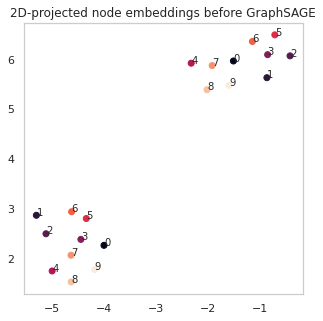

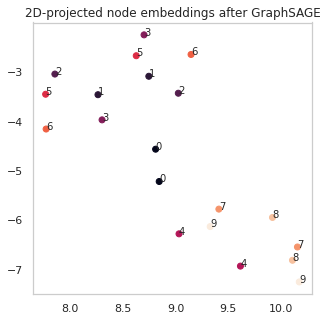

In [164]:
# Plot 2D projections of node embeddings from 10 sampled edges before and after graphSAGE updates

pair_ids = list(range(sample_src_embeds_pre.size(0)))*2
weight_matrix_pre = torch.cat((sample_src_embeds_pre, sample_dst_embeds_pre))
weight_matrix_post = torch.cat((sample_src_embeds_post, sample_dst_embeds_post))

umap_plot(weight_matrix_pre, pair_ids, title='2D-projected node embeddings before GraphSAGE')
umap_plot(weight_matrix_post, pair_ids, title='2D-projected node embeddings after GraphSAGE')

In [165]:
# For 10 samples, get pct change in pairwise cosine similarity for true src-dst pairs and negative pairs

import pandas as pd
from sklearn import metrics

cos_similarities = pd.DataFrame()

pre_sims = metrics.pairwise.cosine_similarity(sample_src_embeds_pre.cpu().detach().numpy(), sample_dst_embeds_pre.cpu().detach().numpy())
post_sims = metrics.pairwise.cosine_similarity(sample_src_embeds_post.cpu().detach().numpy(), sample_dst_embeds_post.cpu().detach().numpy())

for i in range(pre_sims.shape[0]):
    src_dst_sim_pre = pre_sims[i,i]
    non_pair_sims_pre = np.sum(np.concatenate((pre_sims[i,:i],pre_sims[i,i+1:]))) / (len(pre_sims[i])-1)

    src_dst_sim_post = post_sims[i,i]
    non_pair_sims_pos = np.sum(np.concatenate((post_sims[i,:i],post_sims[i,i+1:]))) / (len(post_sims[i])-1)

    cos_similarities = pd.concat([cos_similarities, pd.DataFrame([{'pair_id': i,
                                                                   'src_dst_sim_CLIP': src_dst_sim_pre,
                                                                   'non_pair_sim_CLIP': non_pair_sims_pre,
                                                                   'src_dst_sim_SAGE': src_dst_sim_post,
                                                                   'non_pair_sim_SAGE': non_pair_sims_pos}])])
cos_similarities.reset_index(inplace=True, drop=True)
cos_similarities['pair similarity change'] = (cos_similarities['src_dst_sim_SAGE'] - cos_similarities['src_dst_sim_CLIP']) / cos_similarities['src_dst_sim_CLIP'] * 100
cos_similarities['non-pair similarity change'] = (cos_similarities['non_pair_sim_SAGE'] - cos_similarities['non_pair_sim_CLIP']) / cos_similarities['non_pair_sim_CLIP'] * 100

cos_similarities

,pair_id,src_dst_sim_CLIP,non_pair_sim_CLIP,src_dst_sim_SAGE,non_pair_sim_SAGE,pair similarity change,non-pair similarity change
0,0,0.417100,0.451192,0.081530,0.116294,-80.453247,-74.225108
1,1,0.419340,0.491219,0.526007,0.328588,25.436741,-33.107558
2,2,0.426147,0.484798,0.531073,0.327029,24.622051,-32.543325
3,3,0.426504,0.822067,0.502458,0.310153,17.808580,-62.271520
4,4,0.412316,0.767597,0.559482,0.273596,35.692650,-64.356882
5,5,0.427380,0.490737,0.567933,0.307939,32.887245,-37.249780
6,6,0.430660,0.485647,0.589721,0.301832,36.934116,-37.849523
7,7,0.406417,0.434716,0.572856,0.259213,40.952545,-40.371858
8,8,0.394715,0.468613,0.566719,0.278476,43.576675,-40.574466
9,9,0.408502,0.471926,0.565691,0.262147,38.479519,-44.451612


In [70]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 288 kB 24.4 MB/s eta 0:00:01


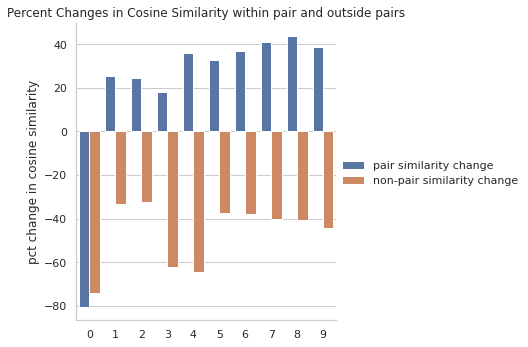

Average pair similarity change: 21.593687
Average non-pair similarity change: -46.70016305508206


In [166]:
import seaborn as sns
sns.set_theme(style='whitegrid')
cos_similarities_tp = pd.melt(cos_similarities, id_vars='pair_id', value_vars=['pair similarity change', 'non-pair similarity change'])

g = sns.catplot(data=cos_similarities_tp, kind='bar', x='pair_id', y='value', hue='variable', errorbar='sd')

g.set_axis_labels('', 'pct change in cosine similarity')
g.legend.set_title('')
plt.title('Percent Changes in Cosine Similarity within pair and outside pairs')
plt.show()

print('Average pair similarity change:', cos_similarities['pair similarity change'].mean())
print('Average non-pair similarity change:', cos_similarities['non-pair similarity change'].mean())


In [167]:
# Run the same analysis as above for all edges in the test dataset and compute average change in cosine similarity for positive pairs and negative pairs

test_dataloader = datamodule.test_dataloader()
val_dataloader = datamodule.val_dataloader()
new_old_node_id_mapping = json.load(open(f'../{cfg.data.zillow_root}/new_old_node_id_mapping.json', 'r'))
cos_similarities = pd.DataFrame()

for batch in tqdm(val_dataloader, desc='computing pre-post cosine sims'):
    inputs, pos_graph, neg_graph, blocks = batch
    pos_mapper = dict(zip(pos_graph.nodes().detach().cpu().numpy(), 
                pos_graph.ndata['_ID'].detach().cpu().numpy()))
    
    # update pos_graph node embeddings
    blocks = [block.to(device) for block in blocks]
    model = model.to(device)
    x = blocks[0].srcdata["feat"]
    logits = model.module(blocks, x)
    pos_graph.ndata["h"] = logits

    src_premap, dst_premap = [x.detach().cpu().numpy() for x in pos_graph.edges()]
    src = [pos_mapper[x] for x in src_premap]
    dst = [pos_mapper[x] for x in dst_premap]
    nodes = [pos_mapper[x] for x in pos_graph.nodes().detach().cpu().tolist()]

    sample_size = 10
    sample_src = src[:sample_size]
    sample_dst = dst[:sample_size]

    src_node_indices = torch.LongTensor([nodes.index(node_id) for node_id in sample_src]).to(device)
    dst_node_indices = torch.LongTensor([nodes.index(node_id) for node_id in sample_dst]).to(device)


    # Embeddings of source and destination nodes in positive graph before and after GraphSAGE updates
    sample_src_embeds_pre = pos_graph.ndata['feat'][src_node_indices]
    sample_dst_embeds_pre = pos_graph.ndata['feat'][dst_node_indices]
    sample_src_embeds_post = pos_graph.ndata['h'][src_node_indices]
    sample_dst_embeds_post = pos_graph.ndata['h'][dst_node_indices]

    pre_sims = metrics.pairwise.cosine_similarity(sample_src_embeds_pre.cpu().detach().numpy(), sample_dst_embeds_pre.cpu().detach().numpy())
    post_sims = metrics.pairwise.cosine_similarity(sample_src_embeds_post.cpu().detach().numpy(), sample_dst_embeds_post.cpu().detach().numpy())

    for i in range(pre_sims.shape[0]):
        src_dst_sim_pre = pre_sims[i,i]
        non_pair_sims_pre = np.sum(np.concatenate((pre_sims[i,:i],pre_sims[i,i+1:]))) / (len(pre_sims[i])-1)

        src_dst_sim_post = post_sims[i,i]
        non_pair_sims_pos = np.sum(np.concatenate((post_sims[i,:i],post_sims[i,i+1:]))) / (len(post_sims[i])-1)

        cos_similarities = pd.concat([cos_similarities, pd.DataFrame([{'pair_id': i,
                                                                    'src_dst_sim_CLIP': src_dst_sim_pre,
                                                                    'non_pair_sim_CLIP': non_pair_sims_pre,
                                                                    'src_dst_sim_SAGE': src_dst_sim_post,
                                                                    'non_pair_sim_SAGE': non_pair_sims_pos}])])

cos_similarities.reset_index(inplace=True, drop=True)
cos_similarities['pair similarity change'] = (cos_similarities['src_dst_sim_SAGE'] - cos_similarities['src_dst_sim_CLIP']) / cos_similarities['src_dst_sim_CLIP'] * 100
cos_similarities['non-pair similarity change'] = (cos_similarities['non_pair_sim_SAGE'] - cos_similarities['non_pair_sim_CLIP']) / cos_similarities['non_pair_sim_CLIP'] * 100

cos_similarities.head()
print('Average pair similarity change:', cos_similarities['pair similarity change'].mean())
print('Average non-pair similarity change:', cos_similarities['non-pair similarity change'].mean())

computing pre-post cosine sims: 100%|██████████| 25/25 [00:00<00:00, 39.08it/s]

Average pair similarity change: 42.653988
Average non-pair similarity change: -61.882028709214545
